In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/beauty-detection-data-set/class_dict.csv
/kaggle/input/beauty-detection-data-set/EfficientNetB1-beauty-100.0.h5
/kaggle/input/beauty-detection-data-set/beauty.csv
/kaggle/input/beauty-detection-data-set/images to predict/5.jpg
/kaggle/input/beauty-detection-data-set/images to predict/1.jpg
/kaggle/input/beauty-detection-data-set/images to predict/4.jpg
/kaggle/input/beauty-detection-data-set/images to predict/3.jpg
/kaggle/input/beauty-detection-data-set/images to predict/2.jpg
/kaggle/input/beauty-detection-data-set/valid/beautiful/029.jpg
/kaggle/input/beauty-detection-data-set/valid/beautiful/014.jpg
/kaggle/input/beauty-detection-data-set/valid/beautiful/150.jpg
/kaggle/input/beauty-detection-data-set/valid/beautiful/109.jpg
/kaggle/input/beauty-detection-data-set/valid/beautiful/034.jpg
/kaggle/input/beauty-detection-data-set/valid/beautiful/149.jpg
/kaggle/input/beauty-detection-data-set/valid/beautiful/024.jpg
/kaggle/input/beauty-detection-data-set/valid/beautiful

In [2]:
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix , classification_report
from keras.models import Model
from keras.layers import Dense,Flatten,Dropout
from keras.applications.vgg16 import VGG16
from keras.preprocessing.image import ImageDataGenerator

In [3]:
train_gen = ImageDataGenerator(rescale = 1./255,
                               horizontal_flip=True,
                               shear_range=0.2,
                               zoom_range=0.2,
                               width_shift_range=0.4,
                               height_shift_range=0.4
)

train_data = train_gen.flow_from_directory('/kaggle/input/beauty-detection-data-set/train',
                                         target_size=(224,224),batch_size=32,
                                         class_mode='categorical')

Found 4000 images belonging to 2 classes.


In [4]:
test_gen = ImageDataGenerator(rescale = 1./255 )

test_data = test_gen.flow_from_directory('/kaggle/input/beauty-detection-data-set/test',
                                       target_size=(224,224),batch_size=32,
                                       class_mode='categorical')

Found 300 images belonging to 2 classes.


In [5]:
valid_gen = ImageDataGenerator(rescale = 1./255 )

valid_data = test_gen.flow_from_directory('/kaggle/input/beauty-detection-data-set/valid',
                                       target_size=(224,224),batch_size=32,
                                       class_mode='categorical')

Found 300 images belonging to 2 classes.


In [6]:
from tensorflow.keras import layers
normalization_layer = layers.Rescaling(1./255)

In [7]:
vgg16 = VGG16(input_shape=(224,224,3),include_top=False,weights='imagenet')


## Don't train existing weights
for layer in vgg16.layers:
    layer.trainable=False
    

## Add layer
x = Flatten()(vgg16.output)
pred = Dense(2,activation='softmax')(x)


## Create a model object
model = Model(inputs=vgg16.input , outputs=pred)



model.summary()

58900480/58889256 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
______________________________________________________________

In [8]:
# Compile the model with the Adam optimizer, binary cross-entropy loss function, and accuracy metric
# This prepares the model for training by specifying the optimizer to use for gradient descent, the loss function to minimize, and the metric to monitor during training and evaluation
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [9]:
history = model.fit(train_data,
                   validation_data=valid_data,
                   epochs=100,
                   steps_per_epoch=len(train_data),
                   validation_steps=len(valid_data),
                   callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=3,
        restore_best_weights=True
    )
])

Epoch 1/100
125/125 [==============================] - 96s 620ms/step - loss: 0.3893 - accuracy: 0.8295 - val_loss: 0.3093 - val_accuracy: 0.8667
Epoch 2/100
125/125 [==============================] - 58s 466ms/step - loss: 0.2673 - accuracy: 0.8940 - val_loss: 0.2262 - val_accuracy: 0.8900
Epoch 3/100
125/125 [==============================] - 58s 466ms/step - loss: 0.2399 - accuracy: 0.9107 - val_loss: 0.1704 - val_accuracy: 0.9267
Epoch 4/100
125/125 [==============================] - 59s 473ms/step - loss: 0.2199 - accuracy: 0.9168 - val_loss: 0.1702 - val_accuracy: 0.9233
Epoch 5/100
125/125 [==============================] - 59s 471ms/step - loss: 0.2077 - accuracy: 0.9160 - val_loss: 0.0705 - val_accuracy: 0.9733
Epoch 6/100
125/125 [==============================] - 59s 469ms/step - loss: 0.1916 - accuracy: 0.9308 - val_loss: 0.0522 - val_accuracy: 0.9867
Epoch 7/100
125/125 [==============================] - 59s 468ms/step - loss: 0.1884 - accuracy: 0.9273 - val_loss: 0.0776 -

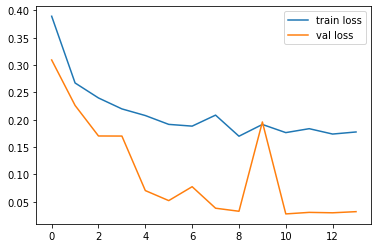

In [10]:
# loss
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.show()

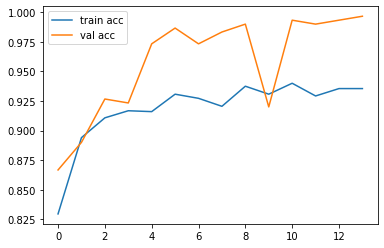

In [11]:
# accuracies
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()

In [12]:
results = model.evaluate(test_data, verbose=0)
loss = results[0]
acc = results[1]

print("    Test Loss: {:.5f}".format(loss))
print("Test Accuracy: {:.2f}%".format(acc * 100))

    Test Loss: 0.04846
Test Accuracy: 98.00%


In [14]:
Y_pred = model.predict(test_data)
y_pred = np.argmax(Y_pred, axis=1)

conf_matrix= confusion_matrix(test_data.classes, y_pred)
print(conf_matrix)

[[72 78]
 [74 76]]


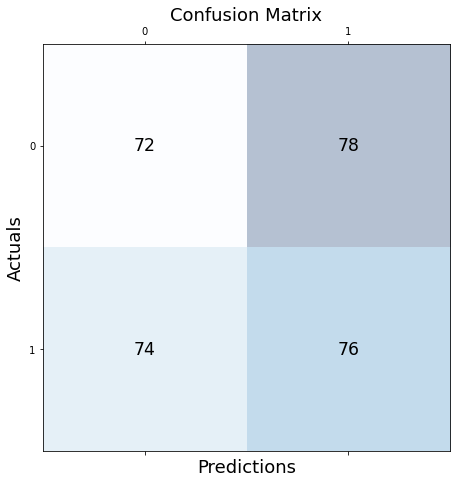

In [15]:

ig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [17]:
report = classification_report(test_data.classes, y_pred, target_names=["AVERAGE", "BEAUTIFULL"])
print(report)

              precision    recall  f1-score   support

     AVERAGE       0.49      0.48      0.49       150
  BEAUTIFULL       0.49      0.51      0.50       150

    accuracy                           0.49       300
   macro avg       0.49      0.49      0.49       300
weighted avg       0.49      0.49      0.49       300



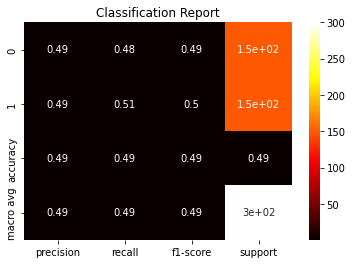

In [19]:
import seaborn as sns



report = classification_report(test_data.classes, y_pred, output_dict=True)

# Convert the report to a DataFrame
df = pd.DataFrame(report).transpose()

# Create a heatmap of the classification report
sns.heatmap(df.iloc[:-1, :].astype(float), annot=True, cmap='hot')
plt.title('Classification Report')
plt.show()

Text(0, 0.5, 'Rate')

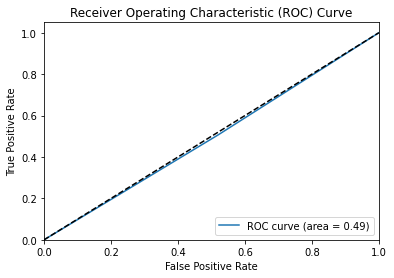

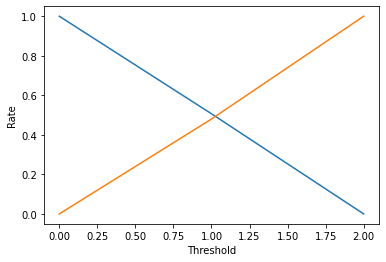

In [20]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

auc_score = roc_auc_score(test_data.classes, y_pred)

# Compute the ROC curve
fpr, tpr, thresholds = roc_curve(test_data.classes, y_pred)

# Plot the ROC curve
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")

# Plot the AUC curve
plt.figure()
plt.plot(thresholds, tpr, label='Sensitivity')
plt.plot(thresholds, 1 - fpr, label='Specificity')
plt.xlabel('Threshold')
plt.ylabel('Rate')

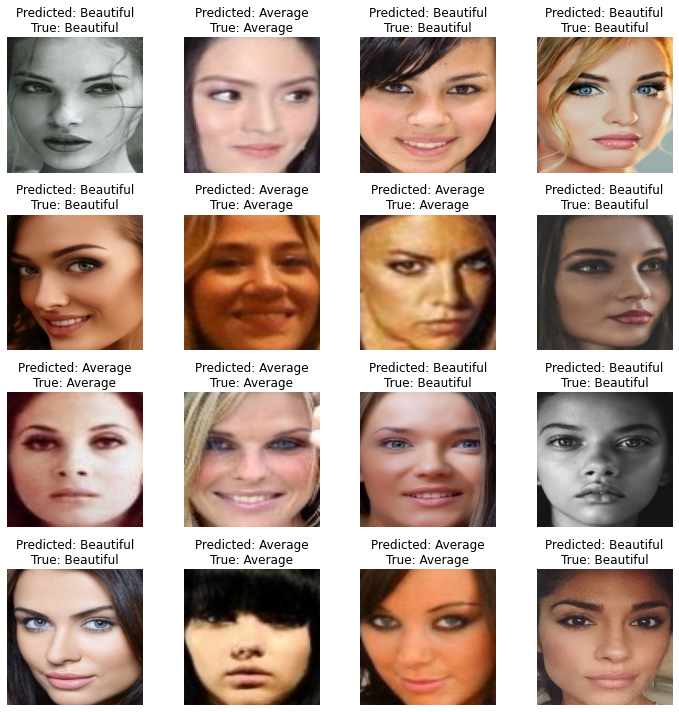

In [21]:
import matplotlib.pyplot as plt
import numpy as np

# Get the first 16 images and their true labels from the test generator
images, labels = next(test_data)

# Use the trained model to predict the classes of the test images
Y_pred = model.predict(images)
y_pred = np.argmax(Y_pred, axis=1)

# Define the class names
class_names = ['Average', 'Beautiful']

# Create a figure with 4 rows and 4 columns for displaying the images and their predicted and true labels
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10,10))

# Loop through each image and its corresponding predicted and true label, and display it on the corresponding subplot
for i, ax in enumerate(axes.flat):
    # Display the image
    ax.imshow(images[i])
    ax.axis('off')
    
    # Get the predicted and true label
    pred_label = y_pred[i]
    true_label = np.argmax(labels[i])
    
    # Set the title based on the true label
    if true_label == 1:
        title = 'Beautiful'
    else:
        title = 'Average'
    ax.set_title("Predicted: {}\nTrue: {}".format(class_names[pred_label], title))
    
    # Stop after displaying the first 16 images
    if i >= 15:
        break
    
plt.tight_layout()
plt.show()

In [22]:
tf.keras.models.save_model(model,'my_model.hdf5')